# SHARP Time Series Data Analysis
Lucas Pauker

## Background
Over the summer, I have been working on analyzing SHARP time series data to understand what conditions lead to solar flares, and why this occurs on a physical level. There is much previous literature about flare prediction, but much of this literature fails to interpret the results in a physically meaningful manner. Furthermore, a time series approach has not been taken before to study this problem.

The magnetic time series data used in this notebook is taken from Helioseismic and Magnetic Imager (HMI) instrument on NASA's Solar Dynamics Observatory (SDO) satellite, which takes magnetic images of the sun at a 12 minute cadence. From these data, [SHARP variables](http://jsoc.stanford.edu/doc/data/hmi/sharp/sharp.htm) are extracted that describe magnetic conditions on the sun. 

Flaring data for the sun is provided by the [NOAA GOES](https://www.swpc.noaa.gov/products/goes-x-ray-flux) database, which keeps track of soft x-ray flux on the sun, which is the metric used to determine whether an active region has flared.

---
First let's import the general utility modules that we will need:

In [1]:
import csv
import json
import requests
import math
import random
from datetime import datetime

And load scientific packages [scipy](http://www.scipy.org), [sunpy](https://sunpy.org), and [numpy](https://www.numpy.org).

In [2]:
import scipy.stats
import sunpy
import sunpy.instr.goes
import numpy as np

---
## Downloading Data

JSOC (Joint Science Operations Center) keeps an up-to-date catalog of all the active regions observed on the sun. This can be found here: `http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt`. The code block below takes a file `./data/all_harps_with_noaa_ars.txt` (which is a downloaded version of the aforementioned link) and extracts the harp_ids, as well as a dictionary of harp_ids corresponding to noaa_ids.

To download the newest version of the file, one could use a tool such as `wget`: `wget http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt`

I will first list the functions for downloading data, then have a cell that runs the functions and saves the relevant data output to variables that are accessible in other methods. Here are the functions:

In [3]:
def get_harp_ids_and_harp_noaa_dict(filename='./data/all_harps_with_noaa_ars.txt'):
    '''This method requires there to be a file filename with two columns: HARP IDs
    and NOAA IDs. This method returns a list of HARP IDs and a dictionary of HARP
    IDs corresponding to a list of NOAA IDs.
    '''
    harp_ids = []
    harp_noaa_dict = {}
    with open(filename) as f:
        content = f.readlines()[1:] # Disregard the header line
        for line in content:
            harp_id = line.split()[0]
            noaa_ids = line.split()[1].split(',')
            harp_ids.append(int(harp_id))
            harp_noaa_dict[int(harp_id)] = noaa_ids
    return harp_ids, harp_noaa_dict

In [4]:
def query_data(harp_id):
    '''This method grabs data from the JSOC database. It queries four variables: time,
    unsigned flux, polarity inversion line flux, and area. This method also makes sure
    that the data received is high-quality and accurate.
    '''
    url_base = 'http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s'
    harp_id_string = '[' + str(harp_id) + ']'
    param_string = '[? (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]'
    # May change to all SHARP variables
    keys_string = '&op=rs_list&key=T_REC,USFLUX,TOTPOT,R_VALUE,AREA_ACR,CRVAL1,CRLN_OBS'
    url = url_base + harp_id_string + param_string + keys_string
    r = requests.get(url)
    assert r.status_code == 200
    data = json.loads(r.text)
    keys = pd.DataFrame()
    for keyword_data in data['keywords']:
        keyword = keyword_data['name']
        vals = keyword_data['values']
        keys[keyword] = vals
    return keys

In [5]:
def convert_tai_to_datetime(t_str):
    '''Helper method to convert a JSOC T_REC object into a python datetime object.'''
    year   = int(t_str[:4])
    month  = int(t_str[5:7])
    day    = int(t_str[8:10])
    hour   = int(t_str[11:13])
    minute = int(t_str[14:16])
    return datetime(year, month, day, hour, minute)

In [6]:
def convert_datetime_to_tai(t_obj):
    '''Helper method to convert a datetime object into a JSOC T_REC object.'''
    return str(t_obj.year) + '.' + str(t_obj.month) + '.' + str(t_obj.day) + '_' \
            + str(t_obj.hour) + ':' + str(t_obj.minute) + '_TAI'

In [7]:
def get_time_delta(start_time, end_time):
    '''This method returns the time difference between two given datetime objects in
    hours.
    '''
    return (end_time - start_time).total_seconds() / (60 * 60) # Convert to hours

In [8]:
def get_time_data(keys):
    '''This method takes a keys object returned from query_data and converts and returns
    the time data from keys.T_REC into a list of relative times, such that the first time
    is zero and the last time is the range of keys.T_REC in hours.
    '''
    start_time = convert_tai_to_datetime(keys.T_REC[0])
    time_data = []
    for i in range(keys.T_REC.size):
        time = convert_tai_to_datetime(keys.T_REC[i])
        time_data.append(get_time_delta(start_time, time))
    return time_data

In [9]:
def create_csv(keys, time_data, harp_id):
    '''Given a keys object from query_data, a time_data list, and a harp_id, this method
    creates a csv file in ./data/[harp_id].csv with six columns: true time (keys.T_REC),
    relative time, unsigned flux, free energy, polarity inversion line flux, and area.
    This method will not write any data that occurs outside the range of +/- 70 degrees
    longitude from the meridian.
    
    The purpose of this method is to write local data so that it is easy and fast to
    access data in the future, since GOES and SHARP data access take a long time, and
    querying every test would be inefficient.
    '''
    data_dir = './data/'
    filename = data_dir + str(harp_id) + '.csv'
    with open(filename, 'w') as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['true_time', 'time', 'unsigned flux', 'free energy',
                        'polarity inversion line flux', 'area'])
        for i in range(len(keys.USFLUX)):
            if abs(float(keys.CRVAL1[i]) - float(keys.CRLN_OBS[i])) < 70.0:
                writer.writerow([keys.T_REC[i], time_data[i], keys.USFLUX[i],
                                 keys.TOTPOT[i], keys.R_VALUE[i], keys.AREA_ACR[i]])

In [10]:
def create_all_csvs(harp_ids):
    '''This method creates a csv file with time and unsigned flux for all the HARP IDs
    in the inputted harp_ids.
    '''
    count = 0
    for harp_id in harp_ids:
        count += 1
        print(count, harp_id)
        if count % 100 == 0: print(count)
        keys = query_data(harp_id)
        time_data = get_time_data(keys)
        create_csv(keys, time_data, harp_id)

In [11]:
import pandas

def read_data(harp_id):
    '''This method reads the data from ./data/[harp_id].csv, and returns a pandas
    DataFrame with two columns: time since the beginning of the active region data,
    and unsigned flux.
    '''
    filename = './data/' + str(harp_id) + '.csv'
    variables = ('T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANJZH,'
                 'TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,SHRGT45,R_VALUE,AREA_ACR'
                )
    key_dict = {'TIME': []}
    for var in variables.split(','):
        if var == 'T_REC': var = 'TRUE_TIME'
        key_dict[var] = []
    with open(filename, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        next(reader)  # Skip header
        for row in reader:
            if 'MISSING' in row: continue
            key_dict['TRUE_TIME'].append(convert_tai_to_datetime(row[0]))
            key_dict['TIME'].append(float(row[1]))
            key_dict['USFLUX'].append(float(row[2]))
            key_dict['MEANGAM'].append(float(row[3]))
            key_dict['MEANGBT'].append(float(row[4]))
            key_dict['MEANGBZ'].append(float(row[5]))
            key_dict['MEANGBH'].append(float(row[6]))
            key_dict['MEANJZD'].append(float(row[7]))
            key_dict['TOTUSJZ'].append(float(row[8]))
            key_dict['MEANJZH'].append(float(row[9]))
            key_dict['TOTUSJH'].append(float(row[10]))
            key_dict['ABSNJZH'].append(float(row[11]))
            key_dict['SAVNCPP'].append(float(row[12]))
            key_dict['MEANPOT'].append(float(row[13]))
            key_dict['TOTPOT'].append(float(row[14]))
            key_dict['MEANSHR'].append(float(row[15]))
            key_dict['SHRGT45'].append(float(row[16]))
            key_dict['R_VALUE'].append(float(row[17]))
            key_dict['AREA_ACR'].append(float(row[18]))
    keys = pandas.DataFrame(key_dict)
    return keys

In [12]:
def get_flare_data_from_database(t_start, t_end, min_event):
    '''This helper method accesses data from the GOES database. It returns
    the metadata associated with each flaring active region greater in event
    size than min_event and between time t_start and t_end.
    '''
    time_range = sunpy.time.TimeRange(t_start, t_end)
    results = sunpy.instr.goes.get_goes_event_list(time_range, min_event)
    return results

In [13]:
def get_flare_data(harp_ids, min_event):
    '''This method accesses the GOES database to get the flare data for the maximum 
    time range of the inputted harp ids.
    '''
    first_keys = query_data(harp_ids[0])
    t_start = first_keys.T_REC[0]
    last_keys = query_data(harp_ids[-1])
    t_end = last_keys.T_REC[len(last_keys.T_REC) - 1]
    print('Time range:', t_start, 'to', t_end)

    return get_flare_data_from_database(t_start, t_end, min_event)

In [14]:
def write_noaa_data_to_csv(flare_data):
    '''This method writes the NOAA flare data to "./data/noaa_data.csv". This makes
    loading the flaring data fast for future runs.
    '''
    with open('./data/noaa_data.csv', 'w') as csv_file:
        field_names = flare_data[0].keys()
        writer = csv.DictWriter(csv_file, fieldnames=field_names)
        writer.writeheader()
        for flare in flare_data:
            writer.writerow(flare)

In [15]:
def get_noaa_data_from_csv():
    '''This method loads the NOAA data from "./data/noaa_data.csv".'''
    noaa_flare_set = []
    with open('./data/noaa_data.csv', 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            noaa_flare_set.append(dict(row))
    return noaa_flare_set

Now we will run the code from the functions above to create `harp_ids`, `harp_noaa_dict`, and `flare_data`:
- `harp_ids`: a list of all HARP IDs
- `harp_noaa_dict`: a dictionary mapping the HARP IDs to the NOAA IDs
- `flare_data`: the flare data downloaded from GOES

In [16]:
# Set recreate_data to True if you want to redownload all the data (takes 30+ minutes)
recreate_data = False

harp_ids, harp_noaa_dict = get_harp_ids_and_harp_noaa_dict()

if recreate_data:
    create_all_csvs(harp_ids)
    flare_data = get_flare_data(harp_ids, 'C1.0')
    write_noaa_data_to_csv(flare_data)
else:
    flare_data = get_noaa_data_from_csv()

print('Number of active regions:', len(harp_ids))
print('Number of flares:', len(flare_data))

Number of active regions: 1335
Number of flares: 8029


---
## Data Processing

In the next blocks of code, we will process the data in various ways to extract information and relate the data described above to each other.

In [17]:
def get_flared_noaa_id_set(flare_data):
    '''This method returns a list of all the NOAA IDs that have flared, based
    on the data passed in from flare_data.
    '''
    noaa_flare_set = set()
    for flare in flare_data:
        noaa_flare_set.add(int(flare['noaa_active_region']))
    return noaa_flare_set

In [18]:
def has_flared(harp_id, harp_noaa_dict, noaa_flare_set):
    '''This method returns a boolean corresponding to whether the active region
    corresponding to the harp_id has flared or not within its lifespan.
    '''
    for noaa_id in harp_noaa_dict[harp_id]:
        if int(noaa_id) in noaa_flare_set:
            return True
    return False

In [19]:
def get_harp_id_to_flaring_times_dict(harp_ids, harp_noaa_dict, flare_data):
    '''This method returns a dictionary where the keys are HARP IDs and
    the values are a list of peak times where the given active region flared.
    Times are given in units of hours after the first time in the harp_id data.
    If the active region corresponding to the HARP IDs did not flare, then
    the list will be empty.
    '''
    # Make a dictionary of NOAA ids as keys and flare times as values
    noaa_id_flare_time_dict = {}
    for flare in flare_data:
        time = flare['peak_time']
        noaa_id = int(flare['noaa_active_region'])
        if noaa_id in noaa_id_flare_time_dict.keys():
            noaa_id_flare_time_dict[noaa_id] += [time]
        else:
            noaa_id_flare_time_dict[noaa_id] = [time]

    # Make a dictionary with HARP ids as keys and flare times as values
    flare_time_dict = {}
    noaa_ids = noaa_id_flare_time_dict.keys()
    for harp_id in harp_ids:
        keys = read_data(harp_id)
        if len(keys.TRUE_TIME) == 0:
            flare_time_dict[harp_id] = []
            continue

        flare_time_dict[harp_id] = []
        datetime_start = keys.TRUE_TIME[0]
        hour_start = keys.TIME[0]
        for noaa_id in harp_noaa_dict[harp_id]:
            if int(noaa_id) not in noaa_ids: continue
            time_array = []
            for time in noaa_id_flare_time_dict[int(noaa_id)]:
                time_array.append(hour_start +
                                  get_time_delta(datetime_start,
                                                 convert_tai_to_datetime(str(time))))
            flare_time_dict[int(harp_id)] += time_array
    return flare_time_dict

In [20]:
def find_unlabeled_flares_above_minimum(flare_data, min_class='M5.0'):
    '''While looking at the NOAA data, I noticed that the NOAA ID of some flares
    were labeled as 0. This method finds and returns flare_data entries that have
    an NOAA ID of 0, and have a GOES class above min_class. This is used to see
    if any of the unlabeled flares interfere with the learning algorithm.
    '''
    unlabeled_flare_list = []
    for flare in flare_data:
        if flare['noaa_active_region'] == '0':
            goes_class = flare['goes_class']
            classes = ['c', 'm', 'x']
            if (
                classes.index(goes_class[0].lower()) > classes.index(min_class[0].lower()) or
                (classes.index(goes_class[0].lower()) == classes.index(min_class[0].lower()) and
                float(goes_class[1:]) > float(min_class[1:]))
            ):
                unlabeled_flare_list.append(flare)
    return unlabeled_flare_list

In [21]:
def count_flared_num(harp_ids, harp_noaa_dict, noaa_flare_set):
    '''This method returns the number of active regions in the inputted
    harp_ids that have flared.
    '''
    number_flared = 0
    for harp_id in harp_ids:
        if has_flared(harp_id, harp_noaa_dict, noaa_flare_set): number_flared += 1
    return number_flared

In [22]:
def get_segmented_data(harp_ids, flare_data, flare_time_dict, n=None,
                       return_harp_ids=False, num_hours=24):
    '''This method returns two arrays: x and y. The x array includes time series
    data, while y represents whether the corresponding active region in x flared.
    
    The x and y arrays are built according to the following rule:
        - If a flare occurs within num_hours hours after sample time t, it is 
        considered to belong to the positive case (i.e. the corresponding y entry
        will be True).
        - If no flare occurs within num_hours hours, it is considered to belong to 
        the snegative case.
    
    The x array is an array of arrays, where each array represents a num_hours-hour
    set of data corresponding to an active region. Each of these num_hours-hour 
    arrays are arrays of dictionaries representing the data at each recorded interval 
    within the num_hours hours.
    
    The n parameter refers to how many negative data points. If n is set to 
    None (default), then the number of negative data points = the number of positive
    data points.
    '''
    num_flares = len(flare_data)
    if n:
        num_samples_per_datapoint = int(20 * n / num_flares)
    else:
        n = len(flare_data) * 5  # Pick a large number
        num_samples_per_datapoint = 10 # Number of negative samples from each region
    
    def get_data_point(time_data, flare_time):
        '''Given a harp_id, returns a dictionary with following keys: time, flux, 
        free energy, area, and polarity_inversion_line, mapping each to the values
        corresponding to the harp_id.
        '''
        data_point = []
        for i, time in enumerate(time_data):
            if time <= flare_time and time >= flare_time - num_hours:
                data_point.append({'time': time,
                                   'flux': keys.USFLUX[i],
                                   'free_energy': keys.TOTPOT[i],
                                   'area': keys.AREA_ACR[i],
                                   'polarity_inversion_flux': keys.R_VALUE[i]})
        if not data_point or data_point[-1]['time'] - data_point[0]['time'] < num_hours - 1: # Insufficient data
            return None
        return data_point

    def contains_nonflaring_24hrs(time_data, flare_data):
        '''Given flaring data flare_data for an active region, returns True if the
        flare_data contains a 24 hour period without flares, and False otherwise.
        '''
        previous_flare_time = time_data[0]
        for flare_time in flare_data:
            if flare_time - previous_flare_time > num_hours:
                return True
            previous_flare_time = flare_time
        return False

    def get_random_flare_time(time_data, flare_data):
        '''Returns a random valid flare time for the given time_data and flare_data.'''
        is_valid = False
        while not is_valid:
            end_time = time_data[random.randrange(len(time_data))]
            for flare_time in flare_data + [time_data[0]]:
                if end_time - flare_time > num_hours: is_valid = True
        return end_time

    x_data = []
    y_data = []
    harp_list = []
    num_negative = 0

    for harp_id in harp_ids:
        keys = read_data(harp_id)
        flare_data = flare_time_dict[harp_id]
        if not flare_data: continue

        # Positive samples
        for flare_time in flare_data:
            # Throw out flare data with less than num_hours hours of preceding data or
            # data that has flare outside of the dataset since the data was cleaned in
            # the downloading data section.
            if flare_time - keys.TIME[0] < num_hours or flare_time > keys.TIME.iloc[-1]: continue
            data_point = get_data_point(keys.TIME, flare_time)
            if data_point:
                harp_list.append(harp_id)
                x_data.append(data_point)
                y_data.append(True) # True => flare is present

        # Negative samples
        for _ in range(num_samples_per_datapoint):
            if not contains_nonflaring_24hrs(keys.TIME, flare_data): break
            flare_time = get_random_flare_time(keys.TIME, flare_data)
            data_point = get_data_point(keys.TIME, flare_time)
            if not data_point: break

            harp_list.append(harp_id)
            x_data.append(data_point)
            y_data.append(False) # False => flare is not present
            num_negative += 1
        if num_negative >= n: break
    if return_harp_ids:
        return x_data, y_data, harp_list
    else:
        return x_data, y_data

In [23]:
flare_time_dict = get_harp_id_to_flaring_times_dict(harp_ids, harp_noaa_dict, flare_data)
seg_x, seg_y, harp_list = get_segmented_data(harp_ids, flare_data, flare_time_dict,
                                             n=4500, return_harp_ids=True)
positive_count, negative_count = 0, 0
for has_flare in seg_y:
    if has_flare: positive_count += 1
    else: negative_count += 1
print('# Positive:', positive_count, '--- # Negative:', negative_count)

# Positive: 4218 --- # Negative: 4500


---
## Plotting Variables over Time

It is useful to create graphs in order to visually understand the relationship between variables over time.

Below are many methods for creating different types of graphs. Many of the functions are flexible, allowing one to manipulate the graphs.

First, let's import `matplotlib` methods useful for graphing:

In [24]:
import matplotlib
import matplotlib.pyplot as plt

In [25]:
def plot_graph(x, y, x_label, y_label, title, clr=None, scatter=False,
               line=None, vertical_lines=None, formula=None, label=None):
    '''This method uses matplotlib to create a graph of x vs. y with many different
    parameters to customize the graph. This method is a base method for many of the
    other graphing methods.
    '''
    # Style elements
    text_style = dict(fontsize=12, fontdict={'family': 'monospace'})

    # Add data to graph
    if scatter:
        plt.scatter(x, y, color=clr, label=label, alpha=0.8, s=5)
    else:
        plot = plt.plot(x, y, '.', color=clr, linestyle=line, label=label)
    
    if vertical_lines:
        for x_val in vertical_lines:
            plt.axvline(x=x_val, color=clr)
    plt.axhline(y=0, color='black', linewidth=1)
    
    if formula:
        x_vals = np.array(x)
        y_vals = formula(x_vals)
        plt.plot(x, y_vals, color=clr)

    # Label the axes and the plot
    ax = plt.gca()
    ax.tick_params(labelsize=12)
    ax.set_xlabel(x_label, **text_style)
    ax.set_ylabel(y_label, **text_style)
    ax.set_title(title, **text_style)
    if label: plt.legend()

In [26]:
def plot_segmented_graphs(seg_x, seg_y, variables=['flux'], flare=True, n=5,
                          color=None, delta=True, scale=False):
    '''This method plots n random graphs that correspond to flaring active regions
    if flare is True, and non-flaring active regions if flare is False.
    If delta is True, it normalizes the graph (variables at time=0 are set to 0).
    If scale is True, it normalizes the graph to be in the range [-1, 1].
    '''
    for _ in range(n):
        i = random.randrange(len(seg_y))
        while seg_y[i] != flare:
            i = random.randrange(len(seg_y))
        seg_data = seg_x[i]
        for variable in variables:
            x_data, y_data = [], []
            start_data = seg_data[0][variable]
            var_data = []
            for data_pt in seg_data:
                var_data.append(data_pt[variable])
            if delta:
                max_data = max(max(var_data - start_data),
                                abs(min(var_data - start_data))) / 1e22
            else:
                max_data = max(max(var_data), abs(min(var_data))) / 1e22
            for data_pt in seg_data:
                x_data.append(data_pt['time'])
                y_pt = data_pt[variable] / 1e22
                if delta:
                    y_pt -= start_data / 1e22
                if scale:
                    y_pt /= max_data
                y_data.append(y_pt)
            variable_names = map(lambda x : x.title().replace('_', ' '), variables)
            plot_graph(x_data, y_data, 'Hours Since Active Region Detected',
                        'Units relative to maximum value',
                        ', '.join(variable_names) + ' vs. Time for Active Region',
                        clr=color, label=variable)
        plt.show()

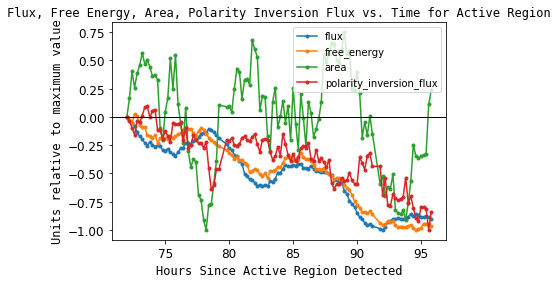

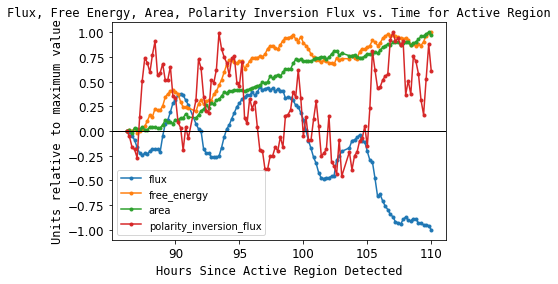

In [27]:
num_graphs = 2
plot_segmented_graphs(seg_x, seg_y, scale=True, flare=True, n=num_graphs,
                      variables=['flux', 'free_energy', 'area', 'polarity_inversion_flux'])

---
## Machine Learning

(from [Wikipedia](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)): Spearman's correlation assesses monotonic relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

In [28]:
def calculate_spearman(seg_x, first_var, second_var):
    '''Calculate the Spearman coefficient between two variables. This method calculates
    the coefficient between the two variables for every time series data series, then
    returns the mean and standard deviation of the coefficients.
    '''
    s_coeff_list = []
    for data in seg_x:
        first_var_data = []
        second_var_data = []
        for data_pt in data:
            if not data_pt[first_var] or not data_pt[second_var]: continue
            first_var_data.append(data_pt[first_var])
            second_var_data.append(data_pt[second_var])
        s_coeff = scipy.stats.spearmanr(first_var_data, second_var_data).correlation
        if not math.isnan(s_coeff): s_coeff_list.append(s_coeff)
    return np.mean(s_coeff_list), np.std(s_coeff_list)

In [29]:
for var in ['free_energy', 'area', 'polarity_inversion_flux']:
    s_coeff, s_dev = calculate_spearman(seg_x, 'flux', var)
    print('S_coefficient for flux vs.', var + '. mean:', s_coeff, ' std:', s_dev)

S_coefficient for flux vs. free_energy. mean: 0.4962321258583314  std: 0.5194315387722125
S_coefficient for flux vs. area. mean: 0.14212229305568824  std: 0.6317008047205964
S_coefficient for flux vs. polarity_inversion_flux. mean: 0.16790397390800682  std: 0.4658001946221718


In [30]:
def regression_helper(function, time_data, variable_data):
    popt, _ = scipy.optimize.curve_fit(function, time_data, variable_data)
    residuals = variable_data - function(time_data, *popt)
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((variable_data - np.mean(variable_data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return popt, r_squared

The following methods take `time_data` and some `variable_data`, then return different kinds of features based on the data.

In [31]:
def linear_features(time_data, variable_data, feature_names=False):
    def f_linear(x, a, b):
        return a * x + b
    popt, r_squared = regression_helper(f_linear, time_data, variable_data)
    if feature_names:
        return np.array([*popt, r_squared]), ['slope', 'intercept', 'r^2_linear']
    return np.array([*popt, r_squared])

In [32]:
def exponential_features(time_data, variable_data, feature_names=False):
    def f_exponential(x, a, b):
        return a * b ** x
    popt, r_squared = regression_helper(f_exponential, time_data, variable_data)
    if feature_names:
        return np.array([popt[1], r_squared]), ['exp_val', 'r^2_exp']
    return np.array([popt[1], r_squared])

In [33]:
def quadratic_features(time_data, variable_data, feature_names=False):
    def f_quad(x, a, b, c):
        return a * x ** 2 + b * x + c
    popt, r_squared = regression_helper(f_quad, time_data, variable_data)
    if feature_names:
        return np.array([*popt, r_squared]), ['quad_1', 'quad_2', 'quad_3', 'r^2_quad']
    return np.array([*popt, r_squared])

In [34]:
def cubic_features(time_data, variable_data, feature_names=False):
    def f_cubic(x, a, b, c, d):
        return a * x ** 3 + b * x ** 2 + c * x + d
    popt, r_squared = regression_helper(f_cubic, time_data, variable_data)
    if feature_names:
        return np.array([*popt, r_squared]), ['cube_1', 'cube_2', 'cube_3', 'cube_4', 'r^2_cube']
    return np.array([*popt, r_squared])

In [35]:
from scipy.interpolate import make_lsq_spline

def spline_features(time_data, variable_data, feature_names=False):
    elapsed_time = time_data[-1] - time_data[0]
    t = [time_data[0] + elapsed_time / 4, time_data[0] + elapsed_time * 2 / 4,
         time_data[0] + elapsed_time * 3 / 4]
    k = 3
    t = np.r_[(time_data[0],)*(k+1), t, (time_data[-1],)*(k+1)]
    try:
        formula = make_lsq_spline(time_data, variable_data, t, k)
    except np.linalg.LinAlgError: # Not enough time data in each quadrant of the data
        if feature_names: return None, None
        return None
    if feature_names:
        return np.array(formula.c), ['spline_1', 'spline_2', 'spline_3', 'spline_4',
                                    'spline_5', 'spline_6', 'spline_7']
    return np.array(formula.c)

In [36]:
def discrete_features(time_data, variable_data, feature_names=False):
    features = []
    features.append(np.mean(variable_data))
    features.append(np.std(variable_data))
    if feature_names:
        return features, ['mean', 'std']

In [37]:
def extract_time_series_features(time_data, variable_data, features):
    feature_list = np.array([])
    feature_names = []
    for feature in features:
        # Each feature is a function
        data, names = feature(time_data, variable_data, feature_names=True)
        if data is None or not any(data): return [], []
        feature_list = np.append(feature_list, data)
        feature_names += names
    return feature_list, feature_names

In [38]:
def create_learning_dataset(seg_x, seg_y, variable, features):
    '''Creates learning dataset with time series data.
    '''
    x_data, y_data = [], []
    for i, data in enumerate(seg_x):
        if len(data) < 4: continue
        time_data, variable_data = [], []
        for data_pt in data:
            time_data.append(data_pt['time'])
            if variable in ['flux', 'free_energy']:
                variable_data.append(data_pt[variable] / 1e22)
            else:
                variable_data.append(data_pt[variable])
        time_data = np.array(time_data)
        variable_data = np.array(variable_data)
        if not any(variable_data): continue
        series_data, names = extract_time_series_features(time_data, variable_data, features)
        if not any(series_data): continue
        x_data.append(series_data)
        y_data.append(seg_y[i])
    names = list(map(lambda x : variable + ' ' + x, names))
    return x_data, y_data, names

In [39]:
features = [linear_features]
raw_x_data = np.array([])
y_data = []
feature_names = []
variables = ['flux']
for variable in variables:
    x, y, names = create_learning_dataset(seg_x, seg_y, variable, features)
    feature_names += names
    if raw_x_data.size == 0: raw_x_data = np.array(x)
    else: raw_x_data = np.hstack((raw_x_data, np.array(x)))
    y_data = y
print('Features used:', feature_names)

Features used: ['flux slope', 'flux intercept', 'flux r^2_linear']


In [40]:
from sklearn.preprocessing import MinMaxScaler

def scale_x_data(x):
    '''Method to scale each feature in the inputted x data to a range of 0 to 1.
    Returns the scaled data.
    '''
    scaler = MinMaxScaler()
    return scaler.fit_transform(x)

In [41]:
x_data = scale_x_data(raw_x_data)
print(len(x_data), len(y_data))

8718 8718


The following two methods are helper functions to help run machine learning algorithms.

In [42]:
from sklearn.model_selection import train_test_split

def fit_algorithm(clf, x, y, n=1):
    '''This method will fit the given classifier clf to the input x, y data
    and will return the training and test accuracy of the model.
    This method will randomize the train/test split n number of times and will
    return the average train/test accuracy.
    '''
    avg_train, avg_test = 0, 0
    for _ in range(n):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
        clf.fit(x_train, y_train)
        avg_train += clf.score(x_train, y_train)
        avg_test += clf.score(x_test, y_test)
    return avg_train / n, avg_test / n

In [43]:
def print_info(clf, x, y, algorithm_name, best_accuracy=0, best_algorithm=None):
    '''This method streamlines the code required to fit the given clf to the 
    model, as well as print out important statistics. This method returns the new
    best algorithm and best accuracy, based on the test accuracy.
    '''
    print(algorithm_name + ':')
    train_accuracy, test_accuracy = fit_algorithm(clf, x, y, 50)
    print('> Train accuracy:', train_accuracy)
    print('> Test accuracy:', test_accuracy)
    result_vals_dict = {'TP': 0, 'FP': 0, 'TN': 0, 'FN':0}
    for i, data_pt in enumerate(x):
        prediction = clf.predict([data_pt])
        if prediction == y[i]:
            if prediction == 1:
                result_vals_dict['TP'] += 1
            else:
                result_vals_dict['TN'] += 1
        else:
            if prediction == 1:
                result_vals_dict['FP'] += 1
            else:
                result_vals_dict['FN'] += 1
    precision = result_vals_dict['TP'] / (result_vals_dict['TP'] + result_vals_dict['FP'] + 1)
    recall = result_vals_dict['TP'] / (result_vals_dict['TP'] + result_vals_dict['FN'] + 1)
    tss_score = recall - result_vals_dict['FP'] / (result_vals_dict['FP'] + result_vals_dict['TN'])
    print('> Precision:', precision)
    print('> Recall:', recall)
    print('> TSS Score:', tss_score)
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_algorithm = algorithm_name
    return best_algorithm, best_accuracy

## Different Classification Algorithms and Their Pros and Cons

1. Suppport Vector Machines (SVMs)
  * SVMs work by constructing hyper-planes in higher dimensional space. This can be used for classification by maximizing the distance between the hyper-plane and the training data of any class.
  * This is a good choice because it is a versatile classification algorithm.
2. Stochastic Gradient Descent
  * Creates a linear classifier to minimize loss.
  * Less versatile than SVMs (this should not be an issue for the binary classification, however).
  * Scikitlearn has the following built-in loss functions: hinge loss, modified Huber, and logistic.
3. Multi-layer Perceptron
  * Can learn non-linear models.
  * Doesn't necessarily find global optimum: different initial weights can alter validation accuracy.
  * Needs tweaking of hyperparameters such as the number of hidden neurons, layers, and iterations to work well.
4. AdaBoost (Boosting algorithm)
  * Principle is to combine many weak learners to create one strong model.
  * Each weak learner concentrates on the examples that are missed by the previous learners.
5. Random Forest
  * Each tree is built from a random sample of the total data (with replacement).
  * This tends to reduce the overall bias.

Let's import all the learning algorithms we need from the scikit learn library:

In [44]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [45]:
def run_learning_algorithms(x, y):
    '''This method runs different machine learning (ML) algorithms and prints 
    statements indicated the accuracy, finally printing the best overall algorithm 
    in terms of test accuracy.
    
    Current ML algorithms:
        Support Vector Machine
        Stochastic Gradient Descent
        Multi-layer Perceptron
        AdaBoost
        Random Forest
    '''
    best_accuracy = 0
    best_algorithm = None

    #algorithm_name = 'Support Vector Machine'
    #clf = SVC(gamma='scale')
    #best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    #print('>', clf.support_vectors_, '\n')

    algorithm_name = 'Stochastic Gradient Descent'
    clf = SGDClassifier(loss='hinge', penalty='l2')
    best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.coef_, '\n')

    #algorithm_name = 'Multi-layer Perceptron'
    #clf = MLPClassifier(max_iter=500)
    #best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    #print('>', clf.loss_, '\n')

    algorithm_name = 'AdaBoost'
    clf = AdaBoostClassifier(n_estimators=25, random_state=0)
    best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.feature_importances_, '\n')

    algorithm_name = 'Random Forest'
    clf = RandomForestClassifier(n_estimators=25, max_depth=2, random_state=0)
    best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.feature_importances_, '\n')

    print('The best algorithm is', best_algorithm, 'with a test accuracy of', best_accuracy)

In [46]:
run_learning_algorithms(x_data, y_data)

Stochastic Gradient Descent:
> Train accuracy: 0.6265616396451515
> Test accuracy: 0.6254770642201833
> Precision: 0.7527047913446677
> Recall: 0.23086039345816545
> TSS Score: 0.15997150456927656
> [[18.52324032 22.12133775  0.34183494]] 

AdaBoost:
> Train accuracy: 0.7110003059039464
> Test accuracy: 0.7024220183486238
> Precision: 0.7087898709520332
> Recall: 0.6899739274709646
> TSS Score: 0.4244183719154091
> [0.48 0.4  0.12] 

Random Forest:
> Train accuracy: 0.6802508412358518
> Test accuracy: 0.6746880733944955
> Precision: 0.690533015115354
> Recall: 0.6172078691633088
> TSS Score: 0.3580967580521977
> [0.49492907 0.39079494 0.11427599] 

The best algorithm is AdaBoost with a test accuracy of 0.7024220183486238


In [47]:
def graph_features(x, y, feature_names, max_num_graphs=float('inf')):
    '''Given the feature data as x, this function will graph features versus each other.
    Different outputs in y will be displayed in different colors. The function will graph
    every combination of features, and print them.
    '''
    single_feature_vectors = [[] for _ in range(len(x[0]))]
    colors = []
    color_map = {True: 'r', False: 'b'}
    for i, data_pt in enumerate(x):
        colors.append(color_map[y[i]])
        for j in range(len(data_pt)):
            single_feature_vectors[j].append(data_pt[j])
    count = 0
    for i in range(len(x[0])):
        for j in range(i + 1, len(x[0])):
            count += 1
            plot_graph(single_feature_vectors[i], single_feature_vectors[j],
                       feature_names[i], feature_names[j],
                       feature_names[i].title() + ' vs. ' + feature_names[j].title(),
                       clr=colors, scatter=True)
            plt.show()
            if count >= max_num_graphs: break
        if count >= max_num_graphs: break

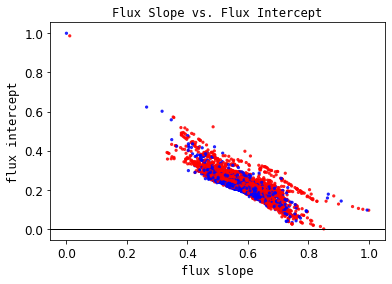

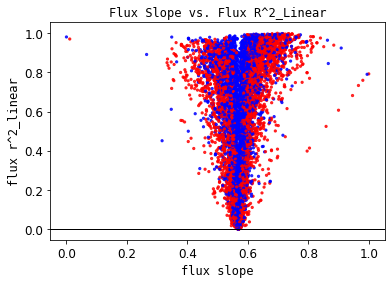

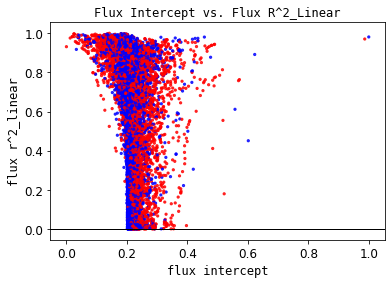

In [48]:
graph_features(x_data, y_data, feature_names)

---
## Plotting Metadata

In this section, I will include a few functions for graphing the results outputted from the machine learning modeling. Specifically, there is a method to understand the relationship between lag time and accuracy and a method to understand the importance of the coefficients in the models as lag time changes.

The following two functions are used to get run the algorithms to get the data ready to be plotted and analyzed:

In [49]:
def lag_vs_accuracy_data(harp_ids, flare_time_dict, seg_x, seg_y, hour_range=range(2, 25),
                         ada=False, features=[spline_features],
                         variables=['flux', 'free_energy', 'area', 'polarity_inversion_flux']):
    '''This function outputs lag time vs coefficient data in the form of a dictionary.
    The dictionary keys are the variables in the variables parameter, and the values are
    a list of three-tuples (lag time, accuracy, accuracy error) for all lag times in the
    hour_range parameter. Note: the model is trained on a single variable with the learning
    algorithm, so there will be len(variables) separate data series.

    The default model used is stochastic gradient descent. If the ada parameter is set to
    True, then an AdaBoost model will be used instead.

    This function takes harp_ids, flare_time_dict, seg_x, and seg_y as inputs.

    Note: The default range does not include hour 1. This is by design: for many of the
    fitting features such as spline_features and cubic_features, it does not make sense to
    fit on one hour (i.e. 5 data points) of data.
    '''
    data_dict = {}
    for variable in variables: data_dict[variable] = [] # List of (time, accuracy, error)
    for lag in hour_range:
        modified_seg_x = []
        # Take time off of the start
        for data in seg_x:
            end_time = data[-1]['time']
            for i, point in enumerate(data):
                if end_time - point['time'] < lag:
                    modified_seg_x.append(data[i:])
                    break
        lag_time = round(modified_seg_x[0][-1]['time'] - modified_seg_x[0][0]['time'])
        for variable in variables:
            # Get data ready for model
            x, y_data, feature_names = create_learning_dataset(modified_seg_x, seg_y, variable, features)
            raw_x_data = np.array(x)
            x_data = scale_x_data(raw_x_data)
            assert(len(x_data) == len(y_data))

            # Run model n times, and take the standard deviation to determine the error
            n = 10
            if ada: clf = AdaBoostClassifier(n_estimators=25, random_state=0)
            else: clf = SGDClassifier(loss='hinge', penalty='l2')
            accuracies = []
            for _ in range(n):
                _, test_accuracy = fit_algorithm(clf, x_data, y_data, 1)
                accuracies.append(test_accuracy)
            accuracy = np.mean(accuracies)
            accuracy_error = np.std(accuracies)
            data_dict[variable].append((lag_time, accuracy, accuracy_error))
    return data_dict

In [50]:
data_dict = lag_vs_accuracy_data(harp_ids, flare_time_dict, seg_x, seg_y,
                                 variables=['flux', 'polarity_inversion_flux'])

In [51]:
def lag_vs_coefficient_data(harp_ids, flare_time_dict, seg_x, seg_y, hour_range=range(2, 25),
                            ada=False, features=[spline_features],
                            f_score=False, variable='flux'):
    '''This function outputs data of lag time vs. coefficient values for a machine learning
    fit. This allows one to see how the relative importance of coefficients changes over time.
    The function returns two lists: coef_data, which is the values of the coefficients at each
    timestep, and time_data, which specifies the timesteps.

    This function, unlike lag_vs_accuracy_data, takes only a single variable and thus runs the
    model on that variable.

    This function also has a f_score parameter. When this is set to true, the coefficient data
    will be the ANOVA F-value computed for each feature for the data. By default this is false,
    and the function returns the parameters of the machine learning fit.

    (The paragraphs below are identical to lag_vs_accuracy_data)
    The default model used is stochastic gradient descent. If the ada parameter is set to
    True, then an AdaBoost model will be used instead.

    This function takes harp_ids, flare_time_dict, seg_x, and seg_y as inputs.

    Note: The default range does not include hour 1. This is by design: for many of the
    fitting features such as spline_features and cubic_features, it does not make sense to
    fit on one hour (i.e. 5 data points) of data.
    '''
    coef_data = []
    time_data = []
    for lag in hour_range:
        modified_seg_x = []
        # Take time off of the start
        for data in seg_x:
            end_time = data[-1]['time']
            for i, point in enumerate(data):
                if end_time - point['time'] < lag:
                    modified_seg_x.append(data[i:])
                    break
        lag_time = round(modified_seg_x[0][-1]['time'] - modified_seg_x[0][0]['time'])
        time_data.append(lag_time)
        ada = True
        x, y_data, feature_names = create_learning_dataset(modified_seg_x, seg_y, variable, features)
        raw_x_data = np.array(x)
        x_data = scale_x_data(raw_x_data)
        assert(len(x_data) == len(y_data))

        # ANOVA F-value does not depend on a machine learning algorithm, so we can save
        # time by not running the ML fit if f_score is True
        if f_score:
            selector = SelectKBest(f_classif, k='all')
            selector.fit(x_data, y_data)
            scores = selector.scores_
            order = np.argsort(selector.scores_)
            ordered_scores = list(map(lambda x : scores[x], order))
            coef_data.append(ordered_scores)
            continue

        # Run model n times, and take the standard deviation to determine the error
        n = 10
        if ada: clf = AdaBoostClassifier(n_estimators=25, random_state=0)
        else: clf = SGDClassifier(loss='hinge', penalty='l2')
        coefs = []
        for _ in range(n):
            _, test_accuracy = fit_algorithm(clf, x_data, y_data, 1)
            if ada: coefs.append(clf.feature_importances_)
            else: coefs.append(clf.coef_[0])
        coef_data.append(sum(coefs) / len(coefs)) # Average coefficients
    return coef_data, time_data

In [52]:
coef_data, time_data = lag_vs_coefficient_data(harp_ids, flare_time_dict, seg_x,
                                               seg_y, variable='flux')

First, let's import methods from the `bokeh` graphing module that we will use to plot data.

In [53]:
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool, Legend, Band, Range1d
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

The next functions are used to plot the data:

In [54]:
def plot_accuracy_data(data_dict):
    '''This function plots the accuracy vs. lag time data of the given input data_dict
    using the bokeh plotting library.
    '''
    accuracy_data, error_data = {}, {}
    time_data, items = [], []
    for var in data_dict:
        # Parse tuples in data_dict
        time_data, accuracy_subset, error_subset= [], [], []
        for tup in data_dict[var]:
            time_data.append(tup[0])
            accuracy_subset.append(tup[1])
            error_subset.append(tup[2])
        accuracy_data[var] = accuracy_subset
        error_data[var] = error_subset

    # Basic plot setup
    plot = figure(plot_width=800, plot_height=300, tools="",
                  toolbar_location=None, title="Lag time vs. accuracy",
                  x_axis_label='Lag time (hr)', y_axis_label='Accuracy')

    circles = []
    colors = ["orange", "green", "red", "blue"]
    min_val = 1
    max_val = 0
    for i, var in enumerate(accuracy_data):
        source = ColumnDataSource(data=dict(
            x_data = time_data,
            y_data = accuracy_data[var],
        ))
        item = plot.line("x_data", "y_data", line_width=1, line_alpha=0.5,
                         color=colors[i], source=source)
        items.append((var.capitalize().replace("_", " "), [item]))
        circles.append(plot.circle("x_data", "y_data", size=10, source=source,
                       fill_color=colors[i], hover_fill_color=colors[i],
                       fill_alpha=0.25, hover_alpha=0.5,
                       line_color=None, hover_line_color="white"))

        # Used for creating error bands
        err_xs, err_ys = [], []
        for x, y, y_err in zip(time_data, accuracy_data[var], error_data[var]):
            if y + y_err / 2 > max_val: max_val = y + y_err / 2
            if y - y_err / 2 < min_val: min_val = y - y_err / 2
            err_xs.append((x, x))
            err_ys.append((y - y_err / 2, y + y_err / 2))

        source = ColumnDataSource({
            'base': time_data,
            'lower': list(map(lambda x : x[0], err_ys)),
            'upper': list(map(lambda x : x[1], err_ys))
        })

        band = Band(base='base', lower='lower', upper='upper', source=source, 
                    level='underlay', fill_alpha=.5, line_width=1,
                    line_color='black', fill_color=colors[i])
        plot.add_layout(band)

    plot.add_tools(HoverTool(tooltips=[("Accuracy", "@y_data %")], renderers=circles,
                             mode='vline'))
    plot.y_range = Range1d(min_val - (max_val - min_val) / 10,
                           max_val  + (max_val - min_val) / 10)
    plot.x_range = Range1d(0, 25)
    legend = Legend(items=items)
    legend.click_policy="hide"
    plot.add_layout(legend, 'right')

    show(plot)

In [55]:
plot_accuracy_data(data_dict)

In [56]:
def plot_coef_data(coef_data, time_data):
    '''This function plots the coefficient data vs. lag time with the bokeh plotting
    library. Each coefficient is displayed as a separate color.
    '''
    coef_data = np.array(coef_data)
    transposed_data = coef_data.transpose()

    sums = []
    for var in coef_data:
        sums.append(sum(list(map(lambda x : abs(x), var))) + 0.01)
    normalized_data = []
    for var in transposed_data:
        normalized_data.append([abs(x) / sums[i] for i, x in enumerate(var)])

    # Basic plot setup
    plot = figure(plot_width=600, plot_height=300, tools="",
                  toolbar_location=None, title="Lag time vs. feature importances",
                  x_axis_label='Lag time (hr)', y_axis_label="Importance")

    circles = []
    colors = ["orange", "green", "red", "blue", "purple", "pink", "black"]
    items = []
    for i, var in enumerate(normalized_data):
        source = ColumnDataSource(data=dict(
            x_data = time_data,
            y_data = var
        ))
        item = plot.line("x_data", "y_data", line_width=1, color=colors[i], source=source)
        items.append(("coef " + str(i + 1), [item]))
        circles.append(plot.circle("x_data", "y_data", size=10, source=source,
                       fill_color=colors[i], hover_fill_color=colors[i],
                       fill_alpha=0.25, hover_alpha=0.5,
                       line_color=None, hover_line_color="white"))

    plot.add_tools(HoverTool(tooltips=[("Importance", "@y_data")], renderers=circles,
                             mode='vline'))
    plot.x_range = Range1d(0, 25)
    legend = Legend(items=items)

    plot.add_layout(legend, 'right')
    plot.legend.click_policy="hide"
    
    show(plot)

In [57]:
plot_coef_data(coef_data, time_data)

The plot above is confusing. If we want to plot only specific features, we can manipulate the `coef_data` before passing it into `plot_coef_data`.

We will splice the data such that we only plot `coef 2` and `coef 6`. These specific variables are meaningful because `coef 2` corresponds to the first half of the lag time and `coef 6` corresponds to the last half of the lag time. This is due to the properties of B-splines. Note: this is only true if we are plotting coefficients for `spline_features`.

In [58]:
spliced_data = list(map(lambda x : [x[1], x[-2]], coef_data))
plot_coef_data(spliced_data, time_data)

Lastly, we have a function that plots the importance of the feature for spline fitting over time. This is built by using the ratios of the two variables above. Since the ratio between the two coefficients corresponds to the relative importance of the first and second half of the lag time, we can make a plot that reflects this.

In [59]:
from sklearn.linear_model import LinearRegression

def plot_spline_feature_importance(coef_data, time_data):
    '''This method takes coefficient data and time data, and creates a plot of the
    importance of the time series data for the spline model over time.
    '''
    first_and_last = list(map(lambda x : [abs(x[1]), abs(x[-2])], coef_data))

    def normalize_points(point):
        '''This method takes a list of two values and returns the normalized list.
        It is normalized such that both numbers sum to 1.
        '''
        if point[0] == 0 and point[1] == 0: return [0.5, 0.5] # Inconclusive
        else:
            point_sum = point[0] + point[1]
            return [point[0] / point_sum, point[1] / point_sum]
    normalized_data = list(map(normalize_points, first_and_last))

    time_dict = {}
    for i, t in enumerate(time_data):
        contains_nan = False
        for coef in normalized_data[i]:
            if np.isnan(coef): contains_nan = True
        if contains_nan: continue
        time_dict[t] = normalized_data[i]

    time_points, data_points, data_point_ranges = [], [], []
    for i, lag_time in enumerate(time_dict.keys()):
        if i == 0:
            time_points += [24 - lag_time * 3/4, 24 - lag_time/4]
            data_points += time_dict[lag_time]
            data_point_ranges += [(24 - lag_time, 24 - lag_time/2),
                                  (24 - lag_time/2, 24)]
        else:
            # Keep track of areas since many areas overlap
            second_half_area, first_half_area = 0, 0
            second_half_range = (24 - lag_time/2, 24)
            first_half_range = (24 - lag_time, 24 - lag_time/2)
            for j, d in enumerate(data_point_ranges):
                second_overlap, first_overlap = 0, 0
                if second_half_range[1] > d[0]:
                    second_overlap = (min(second_half_range[1], d[1]) -
                                      max(second_half_range[0], d[0]))
                    if second_overlap < 0: second_overlap = 0
                second_half_area += second_overlap * data_points[j]
                if first_half_range[1] > d[0]:
                    first_overlap = min(first_half_range[1], d[1]) -  d[0]
                first_half_area += first_overlap * data_points[j]
            width = 1
            # Adding 0.1 smooths the ratios
            ratio = (time_dict[lag_time][0] + 0.1) / (time_dict[lag_time][1] + 0.1)
            if ratio * second_half_area - first_half_area < 0:
                average_ratio = (first_half_area / second_half_area + ratio) / 2
                factor = average_ratio / (first_half_area / second_half_area)
                for k, d in enumerate(data_point_ranges):
                    if first_half_range[1] > d[0]:
                        data_points[k] *= factor
                data_points.append(0)
            else:
                data_points.append((ratio * second_half_area - first_half_area) / width)
            data_point_ranges.append((24 - lag_time, 24 - lag_time + width))
            time_points.append(24 - lag_time * 3/4)

        areas = ([x * (data_point_ranges[i][1] - data_point_ranges[i][0])
                  for i, x in enumerate(data_points)])
        total_area = sum(areas)
        data_points = list(map(lambda x : x / total_area, data_points))

    # Create plot
    plot = figure(plot_width=600, plot_height=300, tools="", x_range=[0,24],
                  toolbar_location=None, title="Feature importance over time",
                  x_axis_label='Time', y_axis_label="Importance")
    source = ColumnDataSource(data=dict(
        x_data = time_points,
        y_data = data_points
    ))
    plot.circle("x_data", "y_data", size=10, source=source,
                fill_color="red", fill_alpha=1, line_color=None)
    # To avoid division by 0, replace all 0s with 0.001
    data_points = list(map(lambda x : x + 0.01, data_points))
    reg = LinearRegression().fit(np.array(time_points).reshape(-1, 1), data_points)
    plot.line([time_data[0], time_data[-1]],
              [reg.predict([[time_data[0]]])[0],
               reg.predict([[time_data[-1]]])[0]], line_width=2)
    show(plot)

In [60]:
plot_spline_feature_importance(coef_data, time_data)